<a href="https://colab.research.google.com/github/SourCherries/VAE-GAN-CelebA/blob/master/z_batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mean Z for every identity in [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

## Load modules

In [5]:
!git clone https://github.com/SourCherries/VAE-GAN-CelebA.git

Cloning into 'VAE-GAN-CelebA'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 157 (delta 31), reused 0 (delta 0), pack-reused 86
Receiving objects: 100% (157/157), 3.06 MiB | 10.44 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [6]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [7]:
import sys, getopt
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n',
          'You should consider updating to Python 3.4.0 or',
          'higher.\n')
print(sys.version)

sys.path.insert(0,'/content/VAE-GAN-CelebA/libs')
sys.path.insert(0,'/content/VAE-GAN-CelebA/')

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import libs.make_network as make_network
import libs.utils as utils
from scipy.io import loadmat, savemat
import imageio
from skimage.util import montage
import pandas as pd
import seaborn as sns

print('TF version = ',tf.__version__)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
TF version =  1.15.2


In [3]:
# Download Tensorflow checkpoint
! gdown --id 1o9nUhtZEX9GZXsTmvCXSNjEjDQ7Q1wHV

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1o9nUhtZEX9GZXsTmvCXSNjEjDQ7Q1wHV
To: /content/vaegan_celeba.ckpt
100% 555M/555M [00:05<00:00, 111MB/s]


## Load images

In [4]:
# https://drive.google.com/file/d/1SLm933s8UgqZqU76dacDIhpPAqRb-FH-/view?usp=sharing
# https://drive.google.com/file/d/1SLm933s8UgqZqU76dacDIhpPAqRb-FH-/view?usp=sharing
! gdown --id 1SLm933s8UgqZqU76dacDIhpPAqRb-FH-

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1SLm933s8UgqZqU76dacDIhpPAqRb-FH-
To: /content/twofaces.zip
100% 188k/188k [00:00<00:00, 78.2MB/s]


Access images from zip?

In [8]:
import zipfile
import io
from PIL import Image

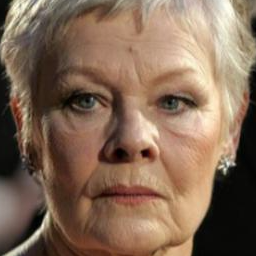

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F37C567DC50>


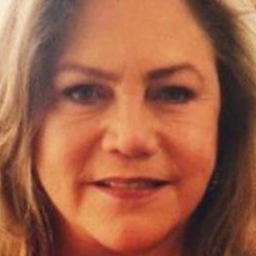

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F37C4DB8E50>


In [12]:
z = zipfile.ZipFile("twofaces.zip")
for i in range(len(z.namelist())):

    file_in_zip = z.namelist()[i]
    if (".png" in file_in_zip or ".PNG" in file_in_zip):

        data = z.read(file_in_zip)
        dataEnc = io.BytesIO(data)
        img = Image.open(dataEnc)
        display(img) #  Jupyter specific function
        print(img)